# How to compute magnetic forces using Force Module

This tutorial shows the different steps to **compute magnetic forces** with pyleecan.
 
The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Force.ipynb).

The first step consists in getting simulation data. In order to demonstrate the capabilities of the plot commands, a simulation over 2048 time steps has been performed in the [simulation tutorial](https://pyleecan.org/tuto_Simulation_FEMM.html), and the resulting **Output** object has been stored on Pyleecan's website. First, these results need to be downloaded:

In [3]:
# Import Pyleecan modules
from pyleecan.Functions.load import load
from pyleecan.definitions import USER_DIR
from os.path import join, isfile
from json import load as jload
import urllib.request

data_path = join(USER_DIR, 'tuto_Simu_FEMM_results.json')

# Download simulation data (if needed)
if not isfile(data_path):
    print('Downloading the simulation data...')
    url = 'https://www.pyleecan.org/Data/tuto_Simu_FEMM_results.json'
    urllib.request.urlretrieve(url, data_path)
    print("Done")

# Load Output object from json file
print("Loading json file...")
out = load(data_path)
print("Done")

Loading json file...
Done


## Force Module
The Force abstract class will make it possible to define different ways of calculating forces. 

The ForceMT class inherits from Force class. ForceMT is dedicated to the computation of air-gap surface force based on the Maxwell stress tensor \[[source](https://eomys.com/IMG/pdf/comparison-main-magnetic.pdf)\]. 

Here, we get the results from a magnetic simulation without any force calculation. The Force module is initialized and run alone. 

In [2]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.ForceMT import ForceMT

# Create the Simulation
mySimu = Simu1(name="Tuto_Force")  
mySimu.parent = out
mySimu.force = ForceMT()

# Run only the force module
mySimu.force.run()

Once the simulation is finished, the results are stored in the force part of the output (i.e. _myResults.force_ ) and we can call different plots. This object contains:   
- *time*: Time vector without symmetry   
- *angle*: Position vector without symmetry   
- *Nt_tot*: Length of the time vector
- *Na_tot*: Length of the angle vector 
- *Prad*: Radial airgap surface force  
- *Ptan*: Tangential airgap surface force
    
**Output** object embbed different plot to visualize results easily. You can find a dedicated tutorial [here](https://www.pyleecan.org/tuto_Plots.html).

Here are some example of useful plots.

<IPython.core.display.Javascript object>


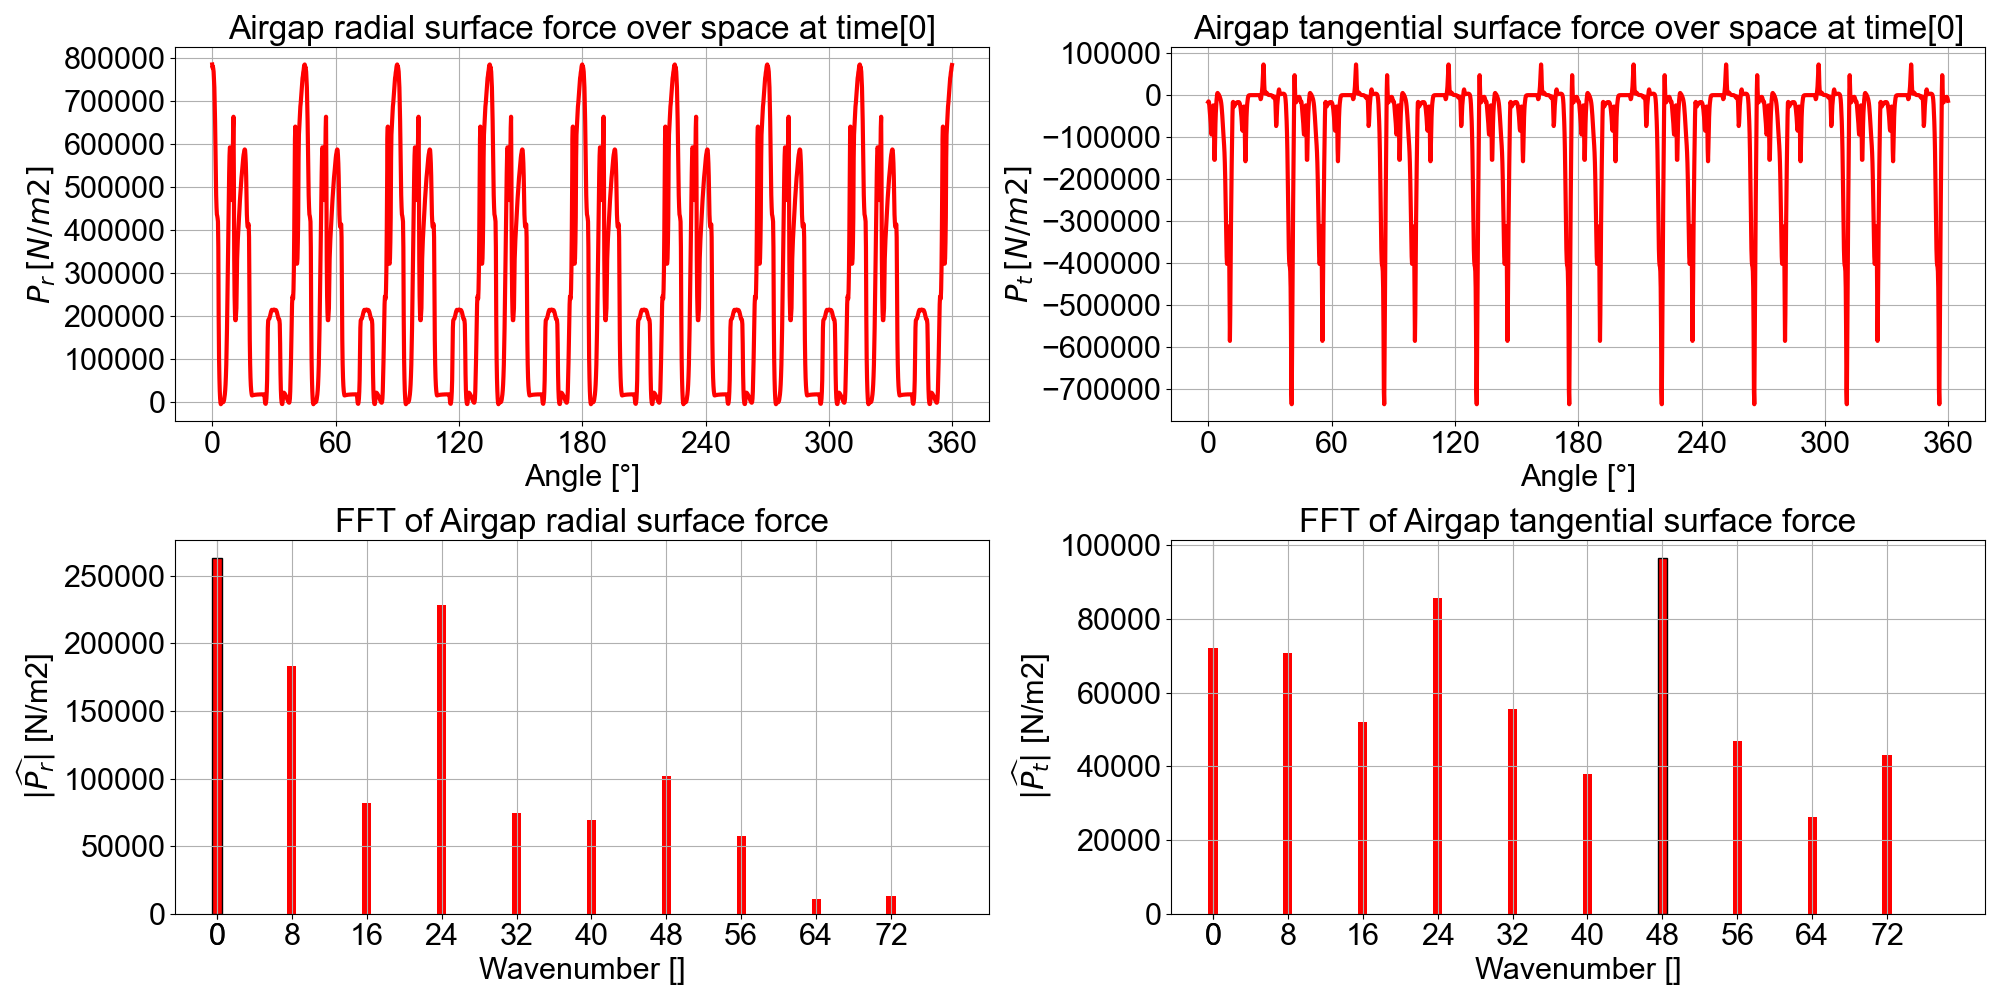

In [3]:
%matplotlib notebook
r_max = 78
out.plot_A_space("force.P", is_fft=True, r_max=r_max)

<IPython.core.display.Javascript object>


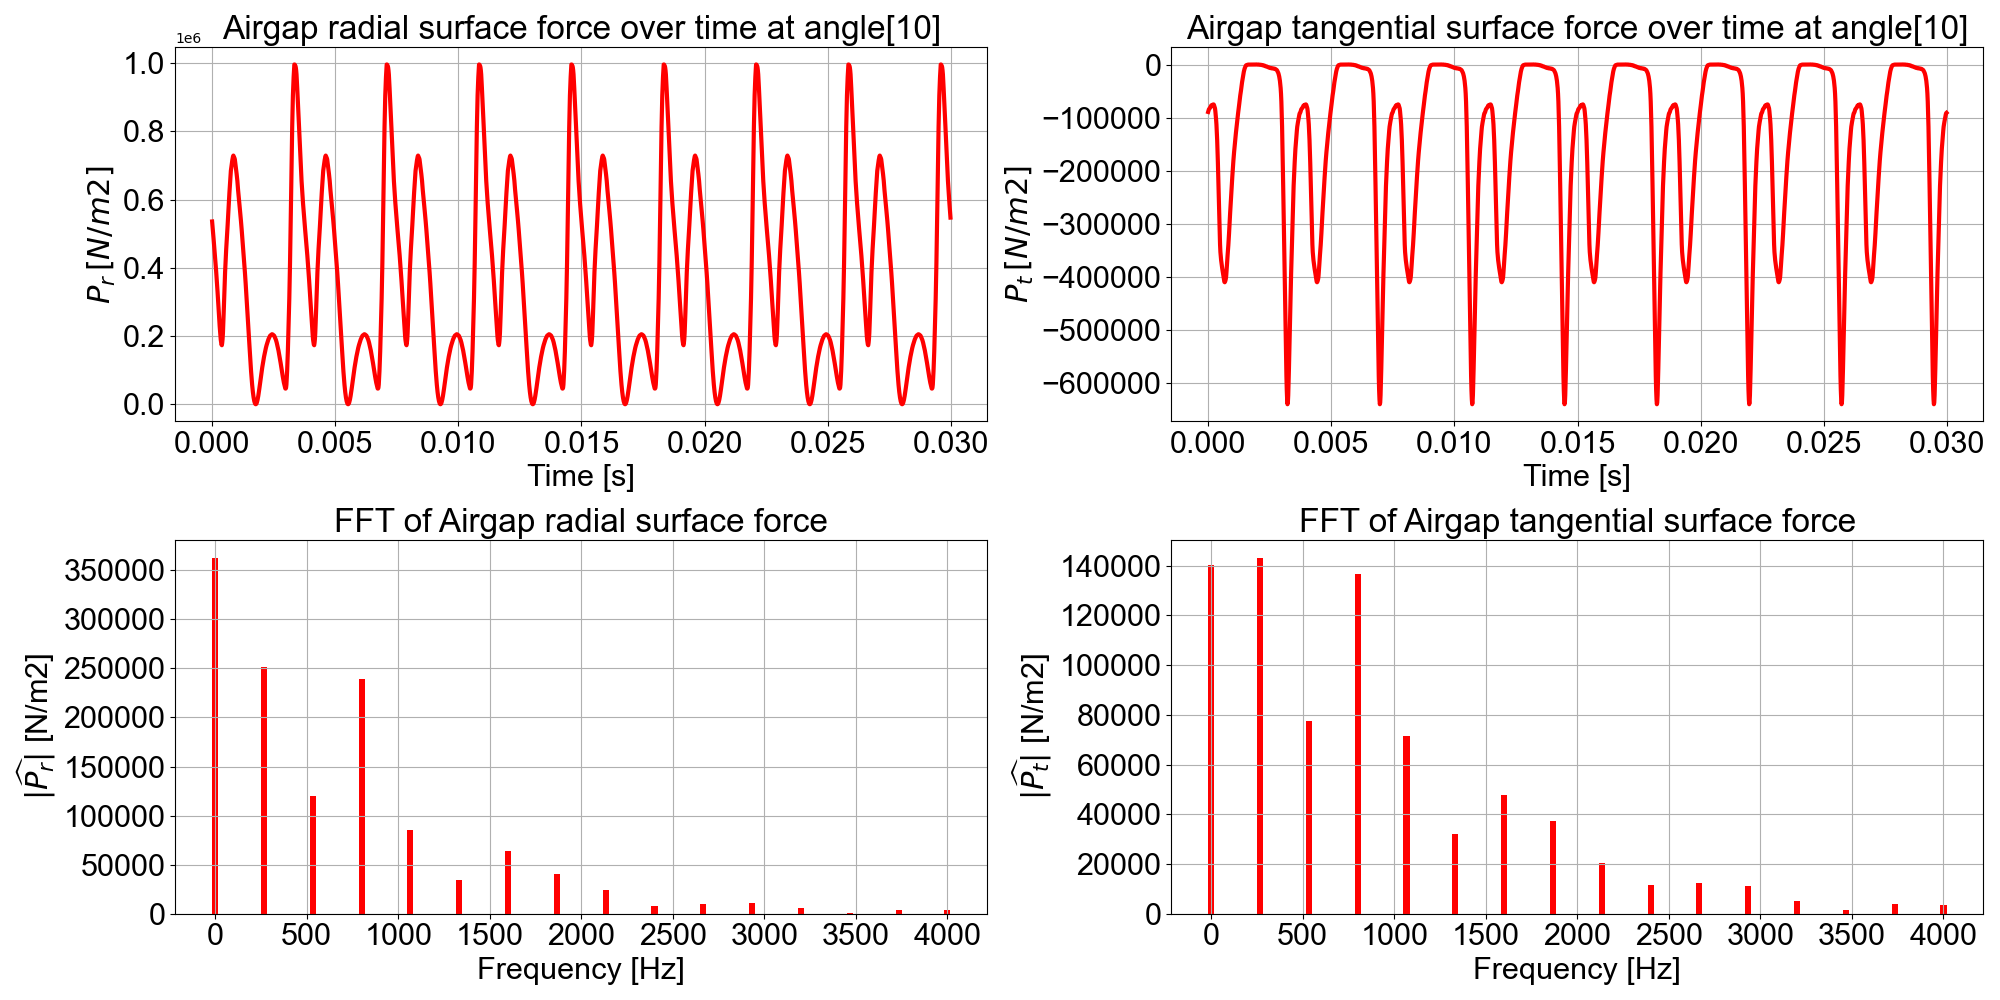

In [4]:
from numpy import pi

#------------------------------------------------------
# Plot the air-gap force as a function of time with the time fft
freq_max = 4000
out.plot_A_time("force.P", alpha_index=10, is_fft=True, freq_max=freq_max, is_auto_ticks=False)
#------------------------------------------------------

You can also define your own plot. 
The following plot requires plotly to display the radial air-gap surface force over time and angle. 

<IPython.core.display.Javascript object>


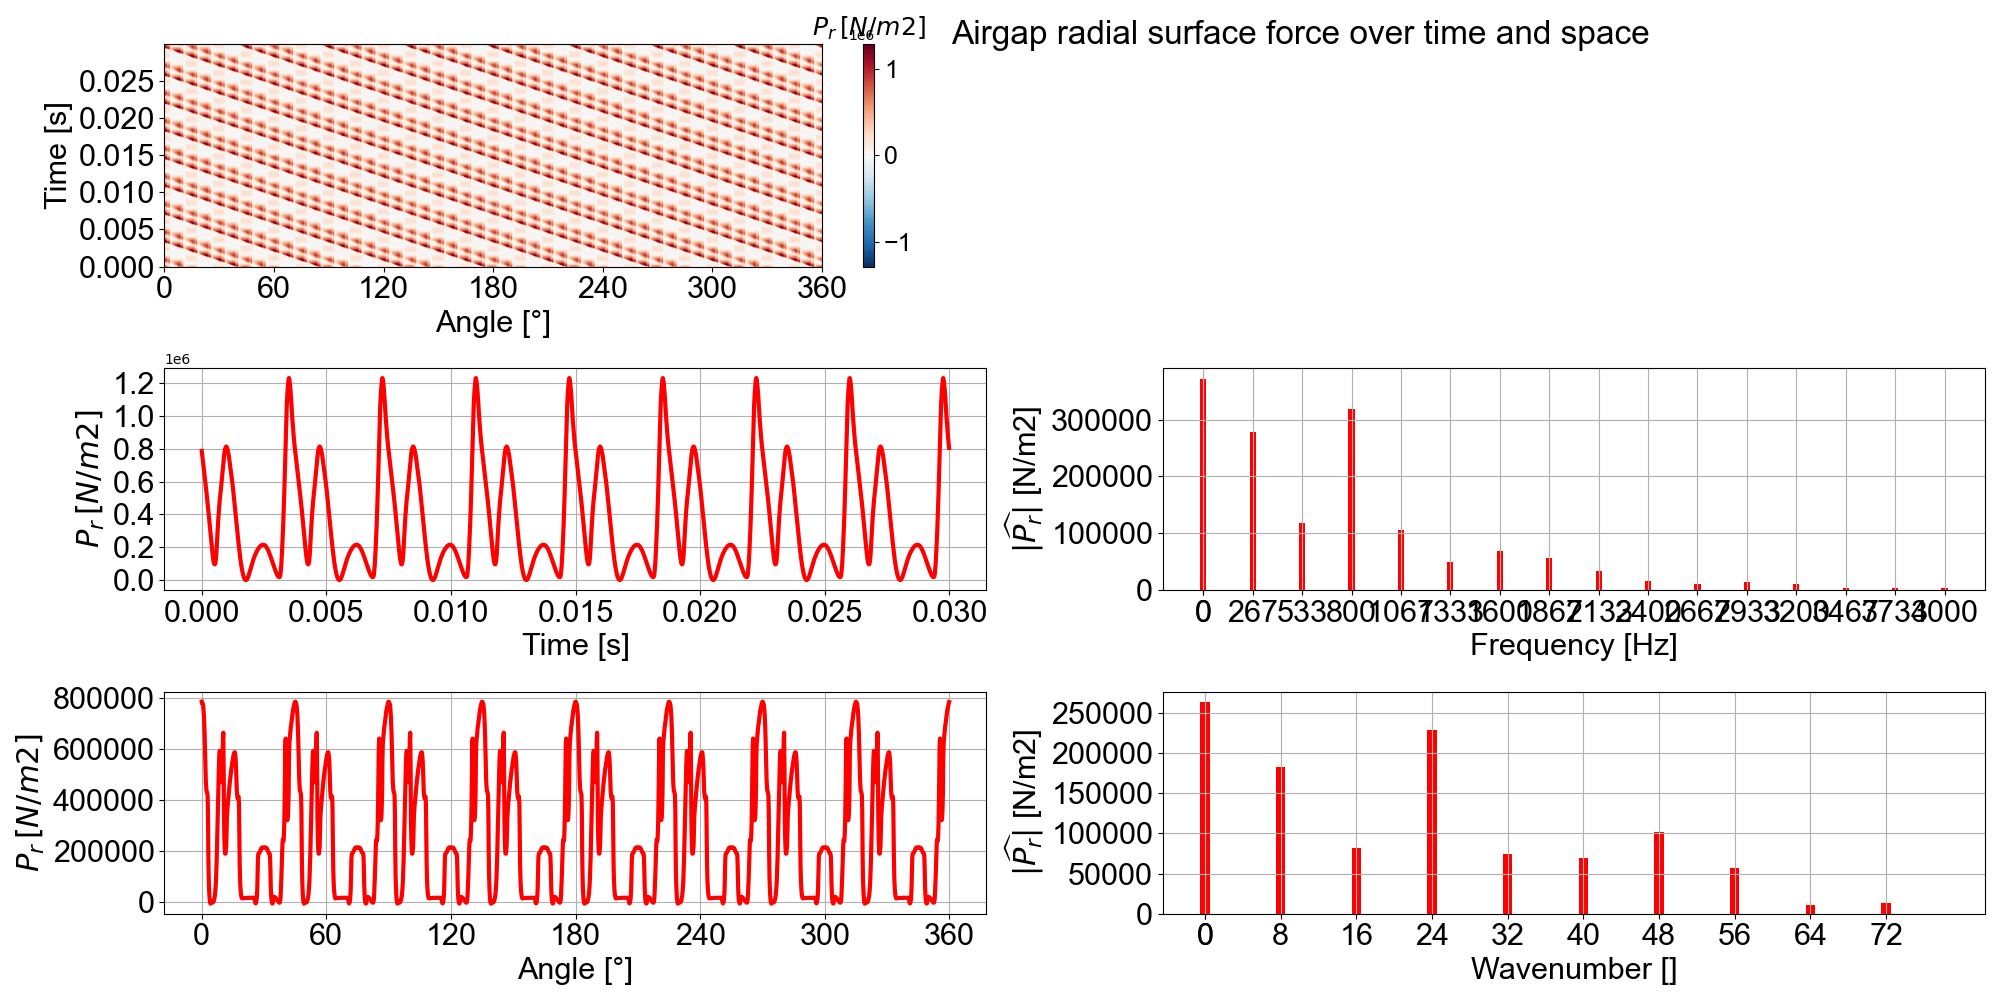

<IPython.core.display.Javascript object>


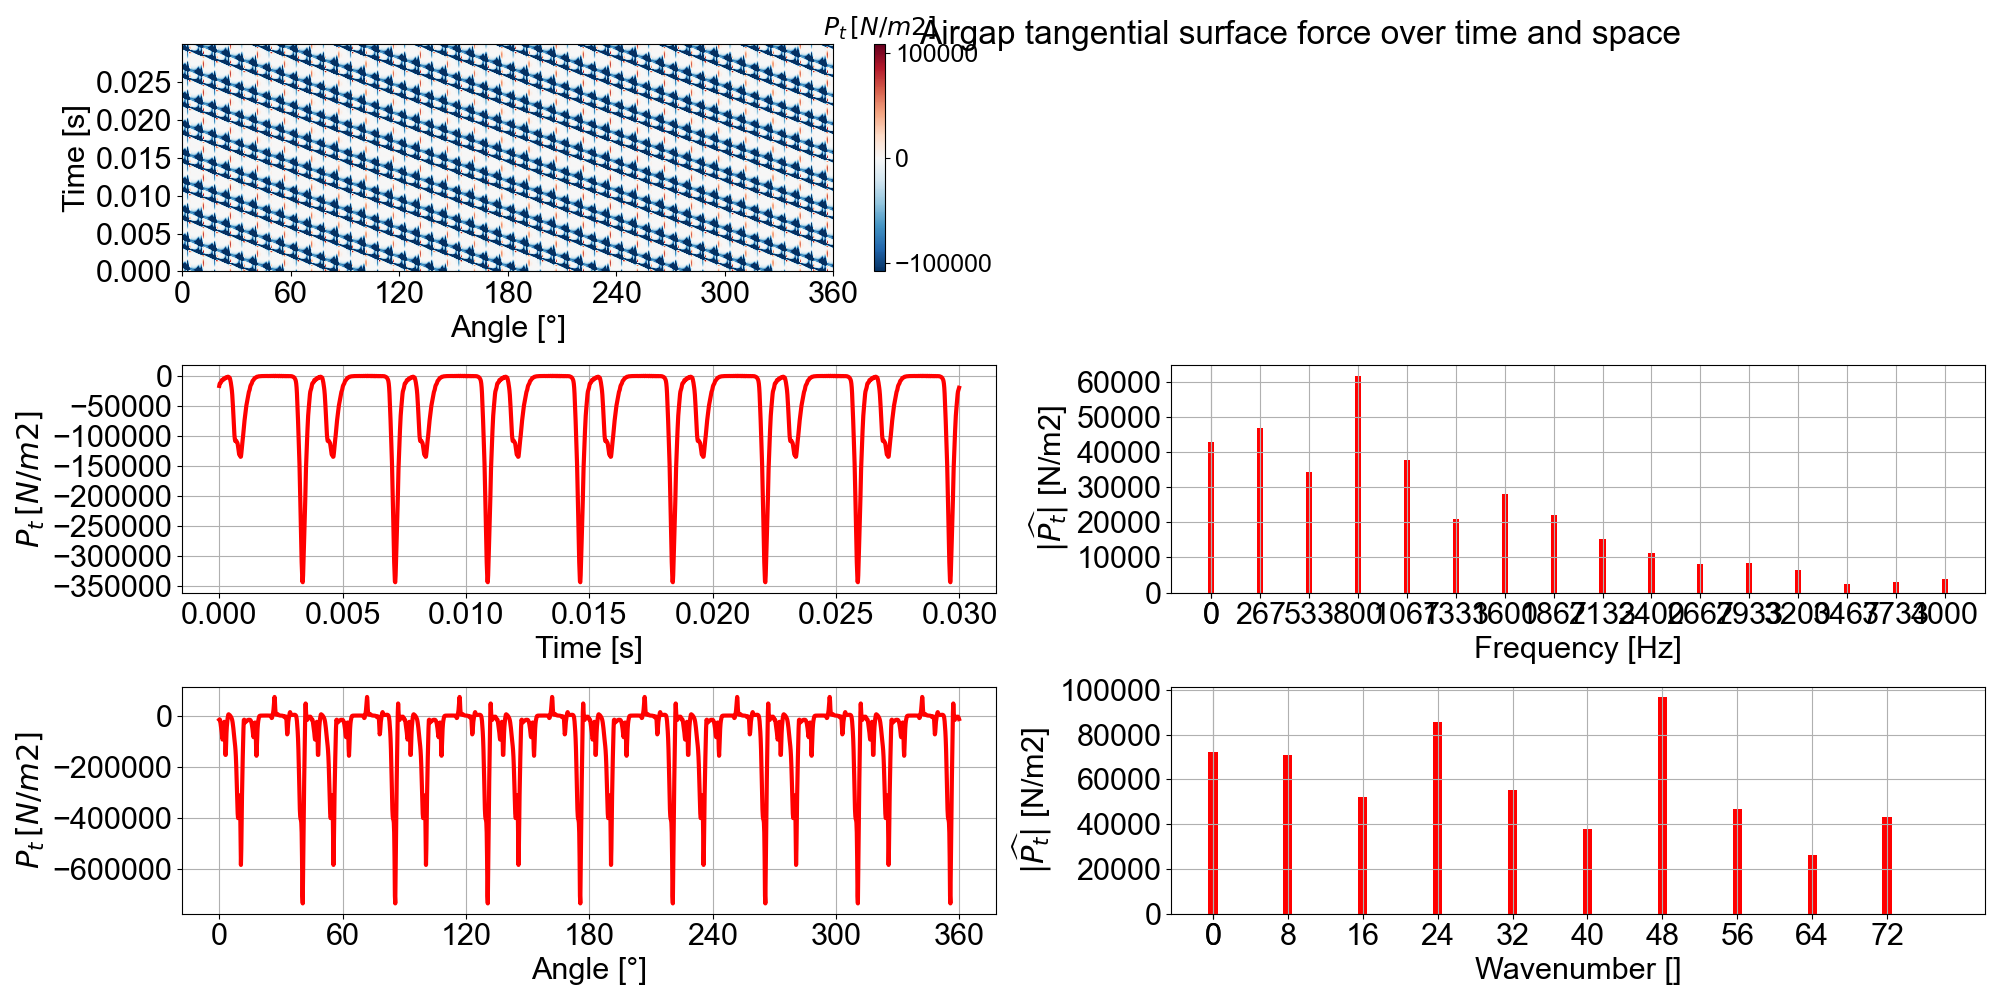

In [5]:
#------------------------------------------------------
# Plot the tangential force as a function of time and space
out.plot_A_time_space("force.P", freq_max=freq_max, r_max=r_max)
#------------------------------------------------------